In [1]:
import os
from uavf_2024.imaging import Camera, Localizer
from scipy.spatial.transform import Rotation as R
from itertools import product
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

files_dir = f"2024_test_data/arc_test"
visualizations_dir = f"visualizations/localizations"
os.makedirs(visualizations_dir, exist_ok=True)

localizer = Localizer.from_focal_length(Camera.focalLengthFromZoomLevel(1), (1920, 1080))

positions = []
drone_orientations = []
cam_orientations = []
start_angles = []
end_angles = []
imgs = []

for i in range(len(os.listdir(files_dir))):
    img_file = f"{files_dir}/img_{i}/bounding_boxes.png"
    pose_file = f"{files_dir}/img_{i}/cam_pose.txt"
    img = cv.imread(img_file)
    imgs.append(img)
    with open(pose_file, 'r') as f:
        lines = f.readlines()

        position = tuple(map(float, lines[0].split(',')))
        drone_orientation = tuple(map(float, lines[1].split(',')))
        cam_orientation = tuple(map(float, lines[2].split(',')))
        start_angle = tuple(map(float, lines[3][1:-2].split(', ')))
        end_angle = tuple(map(float, lines[4][1:-2].split(', ')))

        positions.append(np.array(position))
        drone_orientations.append(R.from_quat(drone_orientation))
        cam_orientations.append(R.from_quat(cam_orientation))
        start_angles.append(np.array(start_angle))
        end_angles.append(np.array(end_angle))


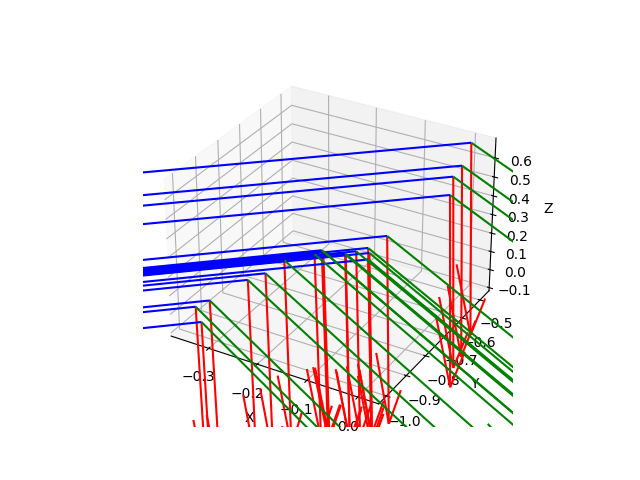

In [2]:
%matplotlib widget 
# initialize 3d plot and draw drone pose as quivers
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for i, (position, orientation) in enumerate(zip(positions[:20], drone_orientations[:20])):
    x_axis = orientation.apply([1,0,0])
    y_axis = orientation.apply([0,1,0])
    z_axis = orientation.apply([0,0,1])
    ax.quiver(*position, x_axis[0], x_axis[1], x_axis[2], color='r')
    ax.quiver(*position, y_axis[0], y_axis[1], y_axis[2], color='g')
    ax.quiver(*position, z_axis[0], z_axis[1], z_axis[2], color='b')
plt.show()

In [5]:

for i, (position, cam_orientation, img) in enumerate(zip(positions, cam_orientations, imgs)):
    for x,y in product(np.linspace(-10, 10, 21), np.linspace(-10, 10, 21)):
        coords_2d = localizer.coords_to_2d(np.array([x,y,0]), (position, cam_orientation))
        coords_2d_int = tuple(map(int, coords_2d))
        if 0<=coords_2d[0]<1920 and 0<=coords_2d[1]<1080:
            cv.putText(img, f"{int(x)},{int(y)}", coords_2d_int, cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            cv.circle(img, coords_2d_int, 5, (255,255,0), -1)
    cv.imwrite(f"{visualizations_dir}/img_{i}_localization.png", img) 